# Recommendations with IBM

Aim of this notebook is to put my recommendation skills to use on real data from the IBM Watson Studio platform. 

In the following section I am buildig out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
pd.options.display.max_colwidth = 100

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VIDEO IS UNAV...",Detect bad readings in real time using Python and Streaming Analytics.,Detect Malfunctioning IoT Sensors with Streaming Analytics,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data science: A ...,"See the forest, see the trees. Here lies the challenge in both performing and presenting an anal...",Communicating data science: A guide to presenting your work,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Paths\r\n * Courses * Our Courses\r\n * Partner Co...,Here’s this week’s news in Data Science and Big Data.,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCALE - BOOST THE PERFORMANCE OF YOUR\r\nDISTRIBUTED ...","Learn how distributed DBs solve the problem of scaling persistent storage, but introduce latency...",DataLayer Conference: Boost the performance of your distributed database,Live,3
4,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VIDEO IS UNAV...",This video demonstrates the power of IBM DataScience Experience using a simple New York State Re...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

`1.` Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

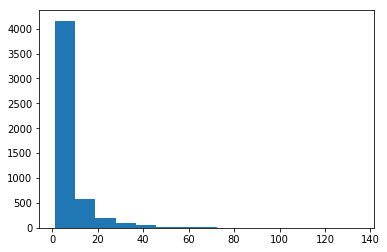

In [6]:
df_interactions = df.groupby("email").nunique()['article_id'].to_frame().reset_index() \
                    .sort_values("article_id" , ascending = False).rename(columns = {"article_id" : "nr_articles"})

plt.hist(df_interactions['nr_articles'] , 15);

In [7]:
df_interactions['nr_articles'].describe()

count    5148.000000
mean        6.540210
std         9.990676
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       135.000000
Name: nr_articles, dtype: float64

In [8]:
median_val = df_interactions['nr_articles'].median()
print(f"50% of individuals interact with {median_val } number of articles or fewer.\n")

50% of individuals interact with 3.0 number of articles or fewer.



In [10]:
df_interactions_2 = df.groupby("email").count()['article_id']
df_interactions_2 = df_interactions_2.to_frame().reset_index().rename(columns = {"article_id": "Nr_interactions"})

df_interactions_2.sort_values(by="Nr_interactions" , ascending = False)
max_views_by_user = df_interactions_2['Nr_interactions'].max()

print(f"The maximum number of user-article interactions by any 1 user is {max_views_by_user}. \n") 

The maximum number of user-article interactions by any 1 user is 364. 



`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [11]:
# Find and explore duplicate articles

df_grouped_id = df_content.groupby("article_id")['article_id'].count().sort_values(ascending = False) \
                          .to_frame().rename(columns ={"article_id":"Count"}).reset_index()


df_grouped_id[df_grouped_id['Count'] > 1]

,article_id,Count
0,221,2
1,232,2
2,577,2
3,398,2
4,50,2


In [12]:
# Remove any rows that have the same article_id - only keep the first

df_content.drop_duplicates(subset = ['article_id'] , keep = 'first' , inplace = True)

`3.` Use below cells to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [13]:
unique_articles = df['article_id'].nunique()
print(f"Number of unique articles that have at least one interaction is {unique_articles}.")

Number of unique articles that have at least one interaction is 714.


In [14]:
total_articles = df_content['article_id'].nunique()
print(f"Number of unique articles on the IBM platform is {total_articles}.")

Number of unique articles on the IBM platform is 1051.


In [15]:
unique_users = df['email'].nunique()
print(f"Number of unique users is {unique_users}.")

Number of unique users is 5148.


In [16]:
user_article_interactions = df.shape[0]
print(f"Total number of user-article interactions in the dataset is {user_article_interactions}.")

Total number of user-article interactions in the dataset is 45993.


`4.` Find the most viewed **article_id**, as well as how often it was viewed.  

In [17]:
#The article_id of the most viewed article is
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [18]:
most_viewed_article_id = df.groupby(["article_id"  ])['email'].count().to_frame() \
                           .rename(columns={"email":"Counts"}).reset_index()  \
                           .sort_values("Counts", ascending = False)['article_id'][:1].item()

most_viewed_article_id = str(most_viewed_article_id)

In [19]:
print(f"The most viewed article in the dataset is {most_viewed_article_id}")

The most viewed article in the dataset is 1429.0


In [21]:
max_views = df.groupby(["article_id"  ])['email'].count().to_frame() \
                           .rename(columns={"email":"Counts"}).reset_index()  \
                           .sort_values("Counts", ascending = False)['Counts'][:1].item()

print(f"The most viewed article in the dataset was viewed {max_views} times.")

The most viewed article in the dataset was viewed 937 times.


Create a function which maps email to a user_id column and removes the email column

In [22]:
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Create a function that returns the **n** top articles ordered with most interactions as the top. 

In [23]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    #Group records of input dataframe by article_id and title; order by count value in descending order
    top_articles = list(df.groupby(["article_id", "title"  ])['user_id'].count().to_frame() \
                           .rename(columns={"user_id":"Counts"}).reset_index()  \
                           .sort_values("Counts", ascending = False)["title"][:n])
    
    #Return titles for top articles
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    #Group records of input dataframe by article_id and title; order by count value in descending order
    top_articles = list(df.groupby(["article_id"  ])['user_id'].count().to_frame() \
                           .rename(columns={"user_id":"Counts"}).reset_index()  \
                           .sort_values("Counts", ascending = False)['article_id'][:n])
    
    
    top_articles = [str(x) for x in top_articles]
    
    #Return IDs for top articles
    return top_articles 

In [24]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

`1.` Create a function to reformat the **df** dataframe to be shaped with users as rows and articles as columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [25]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    #Create a dataframe which has user id as rows and article_ids as columns
    user_item = df.groupby(['user_id', 'article_id'])['title'].min().unstack()
    
    #Replace values with 1s and nulls with 0s
    user_item = user_item.applymap(lambda x: 0 if pd.isnull(x) else 1)
    
    #Return the matrix
    return user_item  

user_item = create_user_item_matrix(df)

`2.` Create a function which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [26]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list from most to least similar
    
    '''

    dot_product = dict()

    #Loop through all the users in user_item dataframe
    for indx in user_item.index:

        #Pass if the input user_id is equal to the user_id in the looping parameter
        if indx == user_id:
            pass
        else:
            #Get the dot product of the array created by the input user and all other users in the dataframe
            dot_product[indx] = user_item.loc[user_id].dot(user_item.loc[indx])
            #Remove records where dot product is zero
            dot_product = {x:y for x,y in dot_product.items() if y!=0}
            
    #Sort the dictionary in descending order and save it as a list      
    most_similar_users = list(dict(sorted(dot_product.items() , key=lambda x:x[1] , reverse=True)))
       
    return most_similar_users 

`3.` Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles to recommend. 

In [28]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Get article names for inputted articleids, save it as a list
    article_names = list(set( df['title'][df['article_id'].isin(article_ids)]))
    
    return article_names 



def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with
                    the list of article ids

    Description:
    Provides a list of the article_ids and article titles that have
    been seen by a user
    '''
    
    #Create a dataframe with all article_ids for the user_id
    user_articles = (user_item.loc[user_id] == 1).to_frame().reset_index()
    #Filter for article_ids seen by the user, save it as a list
    user_articles_lst = list(user_articles['article_id'][user_articles[user_id] == True].astype(str))
    #Get all artcile names by calling above function
    user_articles_names = get_article_names(user_articles_lst, df=df)
    #Return article_ids along with artile names seen by a specific user 
    return user_articles_lst , user_articles_names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    '''
    #Get ids for the inputted user_id
    user_articles_lst = get_user_articles(user_id)[0]

    #Find similar users by calling above function
    similar_users = find_similar_users(user_id,user_item)

    recs = []
    
    #Loop through all similar users 
    for sim_user in similar_users:
        #Loop through all the items inputted user_id has seen
        for i in  get_user_articles(sim_user)[0] :
                #Filter for all items that the inputted user_id has not seen 
                if i not in user_articles_lst and i not in recs:

                        recs.append(i)

                if len(recs) > 10:
                        break
                        
        if len(recs) > 10:
                        break

    return recs 

In [29]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (may 2, 2017)',
 'higher-order logistic regression for large datasets',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'using machine learning to predict parking difficulty',
 'this week in data science (april 18, 2017)',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'using brunel in ipython/jupyter notebooks']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function.

In [30]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    #Get all info related to the inputted user
    specific_user_info = user_item.loc[user_id]
    #Calculate similarity as a dot product and create a dataframe
    df_specific_user_info = user_item.dot(specific_user_info).sort_values(ascending = False) \
                                    .to_frame().reset_index().rename(columns = {0:"Similarity" , 'user_id': 'neighbor_id'})
    #Find number of interactions for each user_id and create a dataframe
    df_nr_interactions = df.groupby('user_id').count()['article_id'].reset_index() \
            .rename(columns ={'user_id':'neighbor_id' , 'article_id':'nr_interactions'} )

    #Merge above dataframes together 
    neighbors_df = pd.merge(df_specific_user_info , df_nr_interactions , on = "neighbor_id" , how = "inner")

    #Sort the dataframe
    neighbors_df = neighbors_df.sort_values(by=['Similarity','nr_interactions'], ascending=False)
    #Remove the row similar to the entered user_id
    neighbors_df = neighbors_df[~ (neighbors_df['neighbor_id'] == user_id)]
    #Drop the index
    neighbors_df = neighbors_df.reset_index().drop(columns = 'index')
    
    return neighbors_df 

In [31]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    #Get top sorted users
    close_neighbors = get_top_sorted_users(user_id)['neighbor_id'] 

    full_df = []
    articles_interactions = {}
 
    #Store articles_ids for each of the close neigbor to the list   
    for i in close_neighbors:
            article_ids = user_item.loc[i][user_item.loc[i] == 1].index
            for j in range(len(article_ids)):
                   full_df.append(article_ids[j])

            full_df = list(set(full_df))

    #Transpose user_item matrix to find total number of interactions for each artile and sort the dict descending
    for j in full_df:

            articles_interactions[j] = user_item.T.loc[j].sum()

            articles_interactions = dict(sorted(articles_interactions.items() , key=lambda x:x[1] , reverse=True))


    recs = list(articles_interactions)[:m]
    rec_names = get_article_names(recs)



    return recs, rec_names

In [33]:
#Testing
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1429.0, 1364.0, 1314.0, 1398.0, 1431.0, 1271.0, 1427.0, 43.0, 1160.0]

The top 10 recommendations for user 20 are the following article names:
['customer demographics and sales', 'total population by country', 'insights from new york car accident reports', 'deep learning with tensorflow course by big data university', 'visualize car data with brunel', 'analyze accident reports on amazon emr spark', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'use deep learning for image classification', 'healthcare python streaming application demo']


These approaches might work well for users for which we have historical data. In cases of new users there is no information available hence we don't have users to compare with each-other. In this situation we can recommend top 10 articles by using function: **get_top_article_ids(10).**

Other ways to make recommendations for new users might be knowledge based or content based recommendation.

### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

`1`. In this part of the notebook, I use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [34]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [35]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, I will use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Afterwards will perform SVD.

In [37]:
# Perform SVD on the User-Item Matrix

u, s, vt = np.linalg.svd(user_item_matrix)
df_na_matrix = user_item_matrix.isna().sum().to_frame().rename(columns = {0:"Na_counts"}).reset_index()
df_na_matrix[df_na_matrix['Na_counts'] > 0]

,article_id,Na_counts


`3.`How do we choose the number of latent features to use?  Below code shows that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.

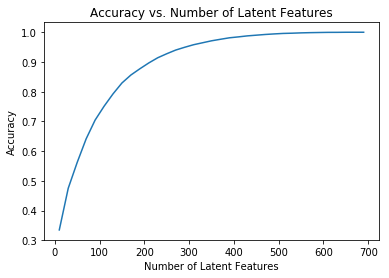

In [38]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

In [39]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    #Use function from previous section to create user_item train and test matrixes
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    #Get a list of all unique  user ids in test set
    test_idx = list(set(user_item_test.index))
    #Get a list of all unique article ids in test set
    test_arts = list(set(user_item_test.T.index))

    #Get a list of all unique user ids in the train set
    train_idx = list(set(user_item_train.index))
    #Get a list of all unique article ids in the train set
    train_arts = list(set(user_item_train.T.index))

    #Find the common ids between training and testing sets to avoid the cold start problem 
    common_ids = set(train_idx).intersection(test_idx) 
    common_arts  = set(train_arts).intersection(test_arts) 

    #Select from test set only the common ids
    user_item_test = user_item_test.loc[common_ids , common_arts]
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

`5.` Use the **user_item_train** dataset from above to find U, S, and V transpose using SVD.
Find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. 

In [40]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)


id_index = user_item_train.index.isin(test_idx)
article_idx = user_item_train.columns.isin(test_arts)

u_test = u_train[id_index, :]
vt_test = vt_train[:, article_idx]


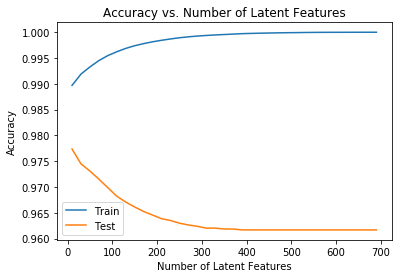

In [41]:
num_latent_feats = np.arange(10,700+10,20)
sum_train_errs  = []
sum_test_errs  = []

#Loop through different numbers in the num_latent_feats

for k in num_latent_feats:
    
    #Filter from datasets for number of k
    s_new_train, u_new_train, vt_new_train , u_new_test, vt_new_test = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :] , u_test[:, :k], vt_test[:k, :]
    
    #Calculate the dot product
    
    user_item_train_dot_prod = np.around(np.dot(np.dot(u_new_train, s_new_train), vt_new_train))
    user_item_test_dot_prod = np.around(np.dot(np.dot(u_new_test, s_new_train), vt_new_test))
    
    #Get the error by subtracting prediction from the true value
    err_diff_train = np.subtract(user_item_train, user_item_train_dot_prod)
    err_diff_test = np.subtract(user_item_test, user_item_test_dot_prod)
    
    
    #Sum for the total errors
    train_err = np.sum(np.sum(np.abs(err_diff_train)))
    test_err  = np.sum(np.sum(np.abs(err_diff_test)))
    
    #Append to the lists
    sum_train_errs.append(train_err)
    sum_test_errs.append(test_err )
    
plt.plot(num_latent_feats, 1 - np.array(sum_train_errs)/(user_item_train.shape[0]*user_item_test.shape[1]), label='Train');
plt.plot(num_latent_feats, 1 - np.array(sum_test_errs )/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

Although the Matrix Factorization yields nice results for small number of latent features, it drops very quickly as the number of latent features increases. As it can be seen from the chart, when number of features passes the number of users (only 20) accuracy drops for testing set and increases for training data, this indicates overfitting - algorithm fits training data very well but doesn't perfom the same in the testing set. 


I think we still need to work to create a better recommendation system. We might need to work in increasing the number of data points/dimensionality, or augment the testing set to overcome the imbalance issue. Also, we can try other ML techniques in combination with A/B testing.